### Imports

In [134]:
# Data Processing Modules
import numpy as np
import pandas as pd
# Model Training Modules
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
# Model Testing Modules
from sklearn import metrics
# Visualization Modules
import matplotlib.pyplot as plt
import seaborn as sns

### Read in Data

In [111]:
df = pd.read_csv('Maths.csv')

In [112]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


### Prepare Target

11.0


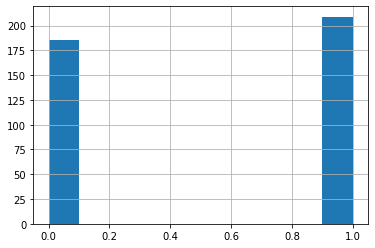

In [113]:
# Create a binary target variable. Is the total grade greater than or equal to the median or not. 
cutoff = df['G3'].median()
print(cutoff)
df['Target'] = (df['G3'] >= cutoff).astype(int)
df['Target'].hist()
df = df.drop(columns=['G1', 'G2', 'G3'])

### Encode Features

In [114]:
# Convert categorical variables to numerical
for feature in df.columns:
    if df[feature].dtype.kind not in 'iufc':
        # Column is not numerical
        df[feature] = df[feature].astype("category")
        df[feature] = df[feature].cat.codes.astype("int")

In [115]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Target
0,0,0,18,1,0,0,4,4,0,4,...,0,0,4,3,4,1,1,3,6,0
1,0,0,17,1,0,1,1,1,0,2,...,1,0,5,3,3,1,1,3,4,0
2,0,0,15,1,1,1,1,1,0,2,...,1,0,4,3,2,2,3,3,10,0
3,0,0,15,1,0,1,4,2,1,3,...,1,1,3,2,2,1,1,5,2,1
4,0,0,16,1,0,1,3,3,2,2,...,0,0,4,3,2,1,2,5,4,0


### Feature Selection

In [116]:
X = df.drop(columns=['Target'])
y = df['Target']

In [117]:
select = SelectKBest(k=10)
X_new = select.fit_transform(X, y)
filt = select.get_support()
features = X.columns

In [118]:
# Print out the top 10 most important features
important_features = features[filt]
print(important_features)

Index(['age', 'address', 'Medu', 'Fedu', 'traveltime', 'failures', 'schoolsup',
       'higher', 'goout', 'Walc'],
      dtype='object')


In [119]:
# Filter data to most important features
X_selected_features = X[important_features]

In [120]:
# # Plots for feature selection
# for important in important_features:
#     # TODO - which plot to use

### Split Data into Training and Testing Sets

In [121]:
# Split data into training and testing sets with a 75/25 split
X_train, X_test, y_train, y_test = train_test_split(X_selected_features, y, test_size=0.25, random_state=0)

### Logistic Regression Classifier

In [122]:
# Train our logistic regression model
logreg = LogisticRegression(random_state=0)
# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.6363636363636364


In [123]:
# Evaluate the logistic regression model using a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[22, 29],
       [ 7, 41]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

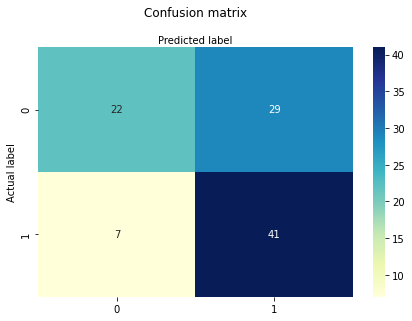

In [124]:
# Visualize Confusion Matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Random Forest Classifier

In [140]:
# Training with cross validation
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

In [141]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

C:\Users\Amit\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 80 candidates, totalling 800 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [50, 66, 83, 100, 116,
                                                         133, 150, 166, 183,
                                                         200]},
                   random_state=0, verbose=2)

In [145]:
rf_model = rf_random.best_estimator_
y_pred = rf_model.predict(X_test)

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.5959595959595959


In [147]:
# Evaluate the RF classifier model using a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[17, 34],
       [ 6, 42]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

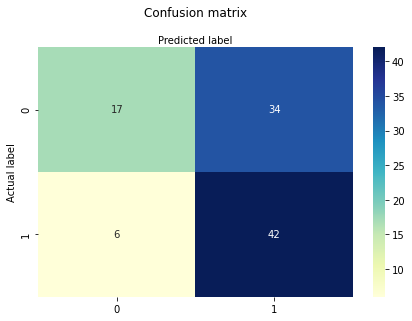

In [148]:
# Visualize Confusion Matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### KNN Classifier

In [128]:
knn_model = KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets
knn_model.fit(X_train,y_train)

# Make predictions
y_pred = knn_model.predict(X_test)

# Test accuracy
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.5454545454545454


In [129]:
# Evaluate the RF classifier model using a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[22, 29],
       [16, 32]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

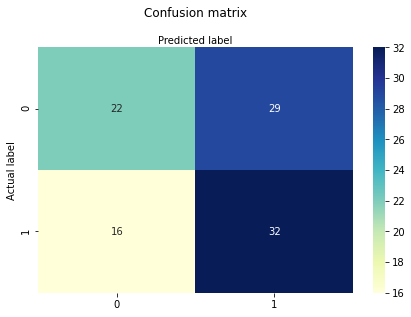

In [130]:
# Visualize Confusion Matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [131]:
# TODO:
# - Cross validation on each model to tune hyperparameters 
# - Select best performing model
# - visualize and show feature importance
# - interpret results